In [86]:
import pandas as pd
import os
import tweepy as tw
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from collections import Counter
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer 
import demoji
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramCollocationFinder, TrigramAssocMeasures
from operator import itemgetter
from sklearn.decomposition import LatentDirichletAllocation as LDA
import warnings
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import pyLDAvis.gensim
from gensim import models
import gensim.corpora as corpora
from nltk.tokenize import word_tokenize
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from nltk import word_tokenize, pos_tag
import networkx as nx
import json
import nltk
import math
import random

In [668]:
consumer_key= #####
consumer_secret= #####
access_token= #####
access_token_secret= #####

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth,wait_on_rate_limit=True)

# Load Data

<i> See topic_collection.ipynb for more details on how tweets were collected. </i>

In [2]:
df = pd.read_csv("./data/df.csv")

In [3]:
print("Number of distinct users:", df.user_id.nunique(),
      "\nNumber of total tweets:", df.id.nunique(),
     "\nNumber of distinct tweets:", df.text.nunique(),
     "\nNumber of retweets:", len(df.loc[df.text.str.startswith("RT")]),
     "\nNumber of distinct retweets:", df.loc[df.text.str.startswith("RT"), "text"].nunique(),
     "\nNumber of distinct original tweets:", df.loc[~df.text.str.startswith("RT"), "text"].nunique())

Number of distinct users: 19667 
Number of total tweets: 24253 
Number of distinct tweets: 14479 
Number of retweets: 12037 
Number of distinct retweets: 2304 
Number of distinct original tweets: 12175


# Preprocessing

## Retrieve full text of retweets

In [5]:
def get_full_text(value):
    '''Gets tweet id and returns the original text if the tweet is a retweet '''
    status = api.get_status(value, tweet_mode="extended")
    try:
        return status.retweeted_status.full_text
    except AttributeError:  # Not a Retweet
        print("not a retweet")
        

In [6]:
df["original_tweet"] = None

In [7]:
# Retrieve original texts of retweets and add to df
for n, text in enumerate(df.loc[df.text.str.startswith("RT"), "text"].unique()):
    value = df.loc[df.text == text, "id"].values[0]
    try:
        original = get_full_text(value)
        df.loc[df.text == text, "original_tweet"] = original
    except:
        continue

In [8]:
# Save the new df.
# It is possible that the texts of some tweets are no longer available. Therefore, do not run this cell. 
df.to_csv("./data/tweets_complete.csv", index=False)

## Retrieve hashtags

In [9]:
df = pd.read_csv("./data/tweets_complete.csv")
df.loc[df.original_tweet.isnull(), "original_tweet"] = None

In [10]:
def get_hashtags(tweet_id):
    '''Gets tweet id and returns a list of the hashtags used in the tweet'''
    original = df.loc[df.id == tweet_id, "original_tweet"].values[0]
    try:
        found = re.findall("#[a-zA-Z]+", original)
    except:
        found = re.findall("#[a-zA-Z]+", df.loc[df.id == tweet_id, "text"].values[0])
    return found

In [11]:
# Assign hashtags to all tweets
df["hashtags"] = None
df["hashtags"] = df["hashtags"].astype('object')

for i in df.index:
    tweet_id = df.loc[i,"id"]
    try:
        lst = get_hashtags(tweet_id)
        df.at[i, "hashtags"] = get_hashtags(tweet_id)
    except Exception as e:
        print(e)
        continue


## Retrieve Emoji

In [12]:
demoji.download_codes()
def get_emoji(tweet_id):
    '''Gets tweet id and returns a list of the emojis used in the tweet'''
    original = df.loc[df.id == tweet_id, "original_tweet"].values[0]
    if original:
        text = original
    else:
        text = df.loc[df.id == tweet_id, "text"].values[0]
    found = list(demoji.findall(text).keys())

    return found


... OK (Got response in 0.63 seconds)
Writing emoji data to C:\Users\Antonella\.demoji\codes.json ...
... OK


In [13]:
# Assign emojis to all tweets
df["emojis"] = None
df["emojis"] = df["emojis"].astype('object')

for i in df.index:
    tweet_id = df.loc[i,"id"]
    try:
        df.at[i, "emojis"] = get_emoji(tweet_id)
    except Exception as e:
        print(e)
        continue

# Data Exploration

## Most retweed tweets (w.r.t. retweet count)

In [2284]:
df.drop_duplicates("text").sort_values("retweet_count", ascending=False)[["original_tweet", "retweet_count"]].head(5)

,original_tweet,retweet_count
14824,"Rep @AOC: ""I do not need Rep. Yoho to apologiz...",85306
15367,queen shit 👑 @AOC https://t.co/XaH24dsNVx,51575
9471,"Rep. Ocasio-Cortez: ""Mr. Yoho mentioned that h...",41849
14630,Ivanka says AOC doesn’t understand the America...,35665
2179,#AOC was right! This heartbreaking video of st...,31988


## Most retweeted tweet (w.r.t. the df)

In [1449]:
#Most retweeted
print(pd.DataFrame(df.loc[df.text.str.startswith("RT")].original_tweet.value_counts()).reset_index().loc[0, "index"])
print("\nRetweeted", 
      pd.DataFrame(df.loc[df.text.str.startswith("RT")].original_tweet.value_counts()).reset_index().loc[0, "original_tweet"],
     "times")


#AOC, If we put your brain on the edge of a razor blade, it would look like a B-B rollin' down a four-lane highway. 
@JennaEllisEsq 
@realDonaldTrump 
@RichardGrenell 
@DonaldJTrumpJr 
@BarbaraRedgate 
@molmccann 
@abigailcfrye 
@atensnut 
@TheLastRefuge2 https://t.co/J3tSe51DJ2

Retweeted 1132 times


## Most frequent hashtags

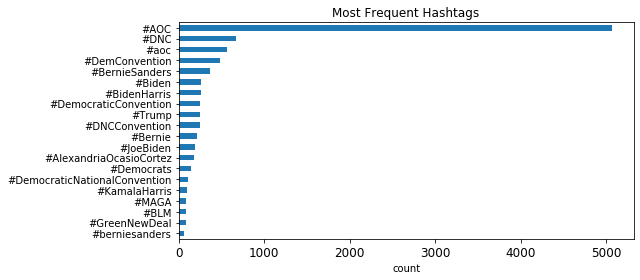

In [322]:
all_hashtags = [item for sublist in df.drop_duplicates("text").hashtags if sublist for item in sublist]

letter_counts = Counter(all_hashtags)
df_hash = pd.DataFrame.from_dict(letter_counts, orient='index').rename({"index":"hashtag", 0:"count"}, axis=1).sort_values("count", ascending=False)[:20].sort_values("count", ascending=True)

df_hash.plot(kind='barh',title="Most Frequent Hashtags", legend=False, figsize=(9,4))
plt.xlabel('count')
plt.xticks(size=12)
plt.tight_layout()
plt.gca().xaxis.grid(False)
plt.show()


## Most frequent emojis

In [14]:
all_emojis = [item for sublist in df.drop_duplicates("text").emojis if sublist for item in sublist]
all_emojis = Counter(all_emojis)
df_em = pd.DataFrame.from_dict(all_emojis, orient='index').rename({"index":"emojis", 0:"count"}, axis=1).sort_values("count", ascending=False)[:10]
df_em

,count
😂,221
🇺🇸,127
🤣,126
❤️,81
🙄,69
🤔,54
👍,35
🔥,31
👏,24
😆,24


## Most active users

In [1451]:
pd.DataFrame(df.user_screen_name.value_counts()).head(5)

,user_screen_name
ShaneCarruth,49
ec0anarch0,41
10WallStreet,38
KidBrightwillow,36
TheBethofDeath,35


## Most followed users

In [2283]:
df.sort_values("friends_count", ascending=False)[["username", "friends_count"]].head(5)

,username,friends_count
13670,Jeffrey Levin,516521
19113,#ismyhairmessedup,444543
9847,Ryan Fournier,308568
11201,Ricky Davila,193599
10774,QT@Anon 🌟🌟🌟,189211


# Text Analysis

## Clean text

In [15]:
stops = stopwords.words('english')
def cleaning(text):
    '''Gets a string, performs cleaning operations, lemmatizes each word in the string and returns cleaned string'''
    lemmatizer = WordNetLemmatizer() 
    text = demoji.replace(text, "")
    text = re.sub(r'https\S+', '', text, flags=re.MULTILINE)
    text = re.sub("&amp;", "and", text)
    text = re.sub(r'@\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\S+', '', text, flags=re.MULTILINE)
    text = re.sub("[^a-zA-Z]+", " ", text.lower())

    text = " ".join([lemmatizer.lemmatize(word) for word in text.split(" ") if word not in stops])
    ret = re.sub(" +", " ", text)
    return ret

In [16]:
df["clean_text"] = None
df.loc[df["original_tweet"].isnull(), "original_tweet"]= None

for n, tweet_id in enumerate(df.id):
    original = df.loc[df.id == tweet_id, "original_tweet"].values[0]
    if original:
        text = original
    else:
        text = df.loc[df.id == tweet_id, "text"].values[0]
        
    df.loc[df.id == tweet_id, "clean_text"] = cleaning(text)

## NGrams

### Single words

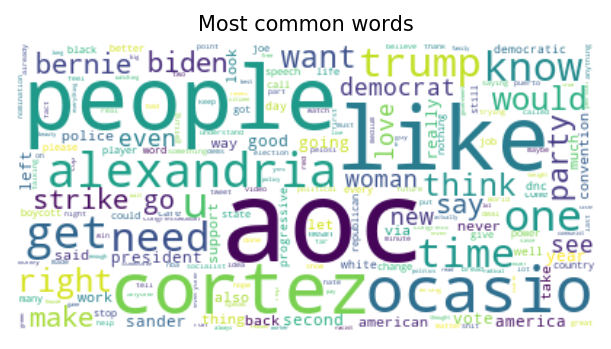

In [17]:
# Join all the texts together.
long_string = ' '.join(list(df['clean_text'].dropna().unique()))

# Create a WordCloud object
plt.figure(figsize=(5,3), dpi=150)
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=1) 
w = wordcloud.generate_from_frequencies(Counter([w.strip() for w in long_string.split(" ")]))

# Visualize the word cloud
plt.title('Most common words', size=10)
plt.imshow(w, interpolation="bilinear")
plt.axis("Off")
plt.show()

### Bigrams

In [60]:
def get_lemmatized_text(list_of_strings):
    '''Gets list of strings and returns a list of all the words cleaned and lemmatized'''
    
    string = ' '.join(list_of_strings)
    
    tokens = nltk.word_tokenize(string)
    text = nltk.Text(tokens)

    # Remove extra chars and remove stop words.
    text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\-]", word)) for word in text]
    text_content = [word for word in text_content if word not in stops]

    # Remove any entries where the len is zero.
    text_content = [s for s in text_content if len(s) != 0]

    # Get the lemmas of each word
    text_content = [WordNetLemmatizer().lemmatize(t) for t in text_content]
    
    return text_content

def get_bigrams(text_content):
    '''Gets list of words and returns dictionary of bigrams with their likelihood_ratio based on their co-appearance'''

    # setup and score the bigrams using the likelihood_ratio
    finder = BigramCollocationFinder.from_words(text_content)
    bigram_measures = BigramAssocMeasures()
    scored = finder.score_ngrams(bigram_measures.likelihood_ratio)

    # Sorting
    scoredList = sorted(scored, key=itemgetter(1), reverse=True)
    word_dict = {}

    listLen = len(scoredList)

    # Create dictionary with bigrams (as continous strings) being the keys and the score as values 
    for i in range(listLen):
        word_dict['_'.join(scoredList[i][0])] = scoredList[i][1]
        
    return word_dict

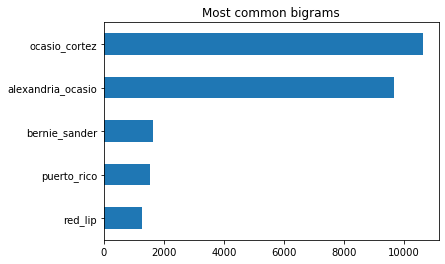

In [61]:
text_content = get_lemmatized_text(df['clean_text'].dropna().unique())
word_dict = get_bigrams(text_content)

comm_big = pd.DataFrame.from_dict(word_dict, orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False).head(5)
comm_big.sort_values('count').plot.barh(legend=False)
plt.title('Most common bigrams')
plt.show()

### Trigrams

In [52]:
def get_trigrams(text_content):
    '''Gets list of words and returns dictionary of trigrams with their likelihood_ratio based on their co-appearance'''
    
    # Setup and score the bigrams using the likelihood_ratio
    finder = TrigramCollocationFinder.from_words(text_content)
    trigram_measures = TrigramAssocMeasures()
    scored = finder.score_ngrams(trigram_measures.likelihood_ratio)
    
    # sorting
    scoredList_tr = sorted(scored, key=itemgetter(1), reverse=True)
    word_dict_tr = {}

    listLen = len(scoredList_tr)

    # Create dictionary with trigrams (as continous strings) being the keys and the score as values 
    for i in range(listLen):
        word_dict_tr['_'.join(scoredList_tr[i][0])] = scoredList_tr[i][1]
        
    return word_dict_tr

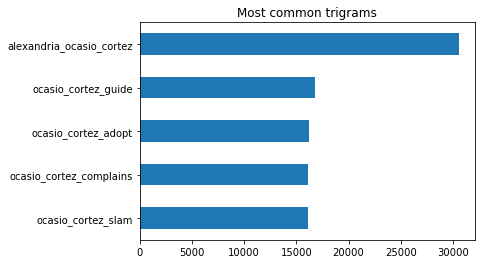

In [62]:
word_dict_tr = get_trigrams(text_content)

comm_trig = pd.DataFrame.from_dict(word_dict_tr, orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False).head(5)
comm_trig.sort_values('count').plot.barh(legend=False)
plt.title('Most common trigrams')
plt.show()

# Topic Modelling

In [82]:
def plot_most_common_words(count_data, count_vectorizer):
    '''Gets total count of data and count vectorizer and plots the most common words'''
    
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure()
    plt.title('10 most common words')
    plt.bar(x_pos, counts)
    plt.xticks(x_pos, words, rotation=60) 
    plt.ylabel('counts')
    plt.show()

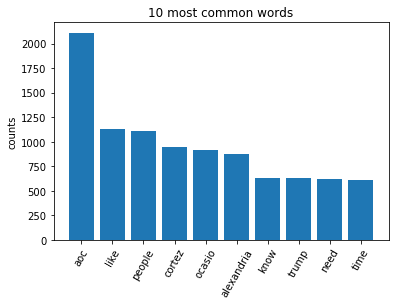

In [83]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the texts
count_data = count_vectorizer.fit_transform(df['clean_text'].dropna().unique())
# Plot the 10 most common words
plot_most_common_words(count_data, count_vectorizer)

In [99]:
def print_topics(model, count_vectorizer, n_top_words):
    '''Gets LDA model, count vectorizer and number of words to shows.
    Prints the most representative words for each topic of the LDA model'''
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(", ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Set parameters
number_topics = 4
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

# Print the topics found by model
print("Topics found")
print_topics(lda, count_vectorizer, number_words)

Topics found

Topic #0:
like, strike, aoc, boycott, player, people, trump, want, nba, time

Topic #1:
know, police, right, aoc, people, think, cop, want, yes, time

Topic #2:
aoc, people, like, need, trump, left, democrat, puerto, say, party

Topic #3:
cortez, ocasio, alexandria, aoc, biden, bernie, sander, president, second, convention


In [95]:
LDAvis_data_filepath = os.path.join('./topic_modelling')

# Save pyLADavis for visualization
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath +'.html')


In [97]:
def is_nouns_adj(text):
    '''Gets word and returns True if the word is noun or adjective, False otherwise '''
    
    is_noun = lambda pos: pos[0][1][:2] == 'NN'
    is_adj = lambda pos: pos[0][1][:2] == 'JJ'
    
    tag = pos_tag(["text"])[0][1]

    return is_noun(pos_tag([text])) | is_adj(pos_tag([text]))

In [108]:
def normalize_document(doc):
    '''Gets a document, performs cleaning operations, lemmatizes each word in the document if it is a noun or an adjective.
    Returns the clean text vectorized'''

    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) #re.I (ignore case), re.A (ASCII-only matching)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = wpt.tokenize(doc)
    
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words and is_nouns_adj(token)] #CONSIDER ONLY NN AND JJ
    
    # Lemmatise document from filtered tokens
    lem_text = [lemmatizer.lemmatize(i) for i in filtered_tokens]
    
    # Remove words that are only one character.
    lem_text = [token for token in lem_text if len(token) > 1]
    
    # Remove numbers, but not words that contain numbers.
    lem_text = [token for token in lem_text if not token.isnumeric()]
    
    doc = ' '.join(lem_text)
    
    return doc

In [ ]:
def compute_coherence_values(corpus, dictionary, texts, end, start, step):
    '''Get corpus, dictionary, texts and number of topics.
    Plots the coherence value for each n of topics.
    Returns the models with their corresponding coherence values'''
   
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, end, step):
    
        # Build LDA model
        lda_model = models.LdaMulticore(corpus=corpus,
                                        id2word=dictionary,
                                        num_topics=num_topics, 
                                        random_state=123,
                                        chunksize=100,
                                        passes=500,
                                        per_word_topics=True)
        model_list.append(lda_model)
        
        #compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values

In [109]:
corpus = df.clean_text.dropna().unique().tolist()

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english') + ["people", "think", "look", "mean", "say"]
lemmatizer = nltk.WordNetLemmatizer()

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)

#Tokenise the corpus
tokenized_corp = [word_tokenize(i) for i in norm_corpus]

# Create Dictionary
id2word = corpora.Dictionary(tokenized_corp)

#Remove words that don't feature 20 times and those that feature in over 50% of documents
id2word.filter_extremes(no_below=20, no_above=0.5)

texts = tokenized_corp

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

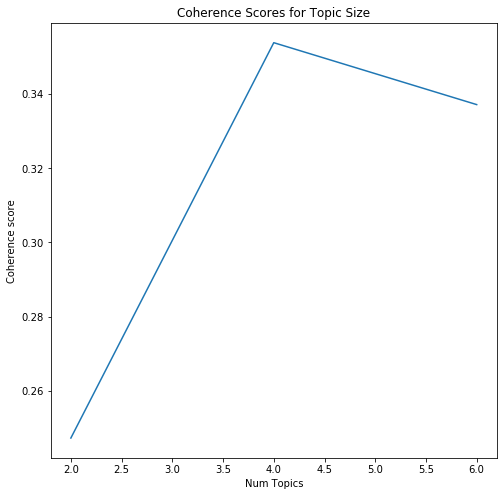

In [205]:
end=8
start=2
step=2

model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary = id2word, texts=texts, start=start, end=end, step=2)

# Show graph

x = np.arange(start, end, step)
ax = plt.subplots(figsize=(8,8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Coherence Scores for Topic Size')
plt.show()

In [110]:
# Re-train the model with the number of topics for which the coherence is the highest, as shown by plot above
BEST_N = 4
lda_model = models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=BEST_N, 
                                       random_state=123,
                                       chunksize=500,
                                       passes=500,
                                       per_word_topics=True)

In [590]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

c:\users\antonella\desktop\antonella\magistrale\2_anno\tirocinio\nlp\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.155565  0.221640       1        1  32.594784
2     -0.062957  0.105719       2        1  27.478605
3      0.199348 -0.251165       3        1  20.618816
1     -0.291956 -0.076194       4        1  19.307798, topic_info=    Category        Freq        Term       Total  loglift  logprob
166  Default  957.000000      cortez  957.000000  30.0000  30.0000
171  Default  936.000000      ocasio  936.000000  29.0000  29.0000
177  Default  897.000000  alexandria  897.000000  28.0000  28.0000
724  Default  646.000000      strike  646.000000  27.0000  27.0000
30   Default  919.000000         dnc  919.000000  26.0000  26.0000
..       ...         ...         ...         ...      ...      ...
139   Topic4  127.360962         job  230.739319   1.0504  -4.8835
322   Topic4  110.470642        part  159.110535   1.2798  -5.0257
209   Topic4  105.208832      matter  161.851700   1.2139  -5.0745
117   Topic4  103.842201       great  161.395172   1.2037  -5.0876
1     Topic4  112.587593       right  597.890381  -0.0250  -5.0067

[191 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
733       4  0.990540      action
177       3  0.998703  alexandria
57        1  0.673646     america
57        2  0.197302     america
57        3  0.104288     america
...     ...       ...         ...
110       2  0.561725        year
110       3  0.193698        year
450       3  0.989733        york
77        1  0.228488     youtube
77        3  0.767973     youtube

[212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

In [121]:
for n, topic in enumerate(lda_model.show_topics(num_words=10)):
    print('Topic {}'.format(n+1))
    print(topic[1])
    print('\n')

Topic 1
0.038*"strike" + 0.019*"police" + 0.019*"boycott" + 0.017*"player" + 0.017*"word" + 0.016*"white" + 0.016*"black" + 0.015*"nba" + 0.012*"cop" + 0.011*"man"


Topic 2
0.033*"aoc" + 0.022*"trump" + 0.018*"party" + 0.015*"democrat" + 0.015*"vote" + 0.014*"america" + 0.014*"left" + 0.013*"woman" + 0.012*"american" + 0.011*"right"


Topic 3
0.051*"cortez" + 0.050*"ocasio" + 0.049*"aoc" + 0.047*"alexandria" + 0.027*"bernie" + 0.022*"biden" + 0.021*"president" + 0.018*"sander" + 0.018*"second" + 0.015*"convention"


Topic 4
0.030*"aoc" + 0.024*"need" + 0.014*"love" + 0.014*"want" + 0.014*"please" + 0.012*"bread" + 0.011*"help" + 0.010*"new" + 0.010*"yes" + 0.010*"right"




In [544]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df.clean_text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        original_ind = df.loc[df.clean_text == unique_tweets.loc[i, "text"]].index.values
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([original_ind, int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,[0],2.0,0.8100,"need, right, police, black, white, want, time,...",aoc right poor thing look hunger making
1,"[1, 271, 1452, 2185, 2457, 2721, 3001, 3602, 5...",2.0,0.5624,"need, right, police, black, white, want, time,...",infobit hdmi pin gbps active optical cable ao...
2,[2],3.0,0.6250,"cortez, ocasio, alexandria, love, woman, congr...",aoc love
3,[3],1.0,0.7335,"strike, boycott, nba, word, player, work, poin...",champagne champagnelovers winelovers aoc happ...
4,"[4, 27, 33, 51, 56, 59, 212, 232]",3.0,0.8089,"cortez, ocasio, alexandria, love, woman, congr...",coming ereader near preorder faith christian r...
5,"[5, 11, 3202, 3207, 3220, 3227, 3673, 7432, 87...",0.0,0.4502,"dnc, trump, biden, bernie, democrat, party, jo...",migrantjustice blackagenda fuckice shimby nop...
6,"[6, 12, 3203, 3206, 3221, 3228, 3665, 3666, 36...",0.0,0.3751,"dnc, trump, biden, bernie, democrat, party, jo...",fuckice migrantjustice shimby justiceforchiri...
7,"[7, 10, 3204, 3205, 3222, 3226, 3663, 3667, 36...",0.0,0.6057,"dnc, trump, biden, bernie, democrat, party, jo...",herodavidross miller green mountain veteran p...
8,"[8, 9, 3200, 3201, 3223, 3224, 3664, 3668, 367...",0.0,0.4502,"dnc, trump, biden, bernie, democrat, party, jo...",transgender transidentity trans transequality...
9,[13],0.0,0.6941,"dnc, trump, biden, bernie, democrat, party, jo...",transgender transidentity trans transequality...


In [519]:
topics = [lda_model[corpus[i]] for i in range(len(df.clean_text.dropna().unique()))]
def topics_document_to_dataframe(topics_document, num_topics=4):
    res = pd.DataFrame(columns=range(4))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

document_topic = pd.concat([topics_document_to_dataframe(topics_document[0], num_topics=4) for topics_document in topics]).reset_index(drop=True).fillna(0)
document_topic.head()


,0,1,2,3
0,0.063102,0.063984,0.810017,0.062898
1,0.062509,0.312610,0.562370,0.062510
2,0.125001,0.125001,0.125001,0.624997
3,0.085885,0.733312,0.093950,0.086853
4,0.063214,0.062507,0.065382,0.808897


In [649]:
print(df.loc[df.clean_text == unique_tweets.loc[4836, "text"], "text"].values[0])


Alexandria Ocasio-Cortez slams ‘proud’ Latina Kimberly Guilfoyle for saying her Puerto Rican mother is an immigrant https://t.co/mcu4IOZ6zZ 
Puerto Rico is part of the United States, but then
Trump didn't even know that, and today the @GOP is whatever Trump is (on that day).


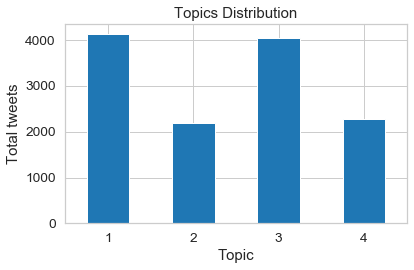

In [656]:
document_topic.idxmax(axis=1).value_counts().sort_index().plot.bar()
plt.xticks(rotation=0)
plt.xlabel("Topic")
plt.ylabel("Total tweets")
plt.xticks(range(4), range(1,5))
plt.title("Topics Distribution")
plt.tight_layout()
plt.show()


# Further analysis

## Hate Speech Detection

I wanted to investigate the use of <b>offensive words</b> in tweets. To do so, after creating an account, I downloaded the vocabulary available at https://hatebase.org/how_it_works.
\
Since Hatebase does not allow for the redistribution of its data, the json files that I used are not available in the data folder. Therefore, the following cells will not work.

In [124]:
hate = pd.DataFrame()
for n in range(1,39):
    data = json.load(open("./data/hate/voc{}.json".format(n)))
    hate = hate.append(pd.DataFrame(data["result"]))

In [125]:
lbl = ['is_about_nationality', 'is_about_ethnicity', 'is_about_religion',
       'is_about_gender', 'is_about_sexual_orientation', 'is_about_disability',
       'is_about_class']

for t in hate.term:
    hate.loc[hate.term == t, "label"] = str([lab.split("_")[-1] for lab in lbl if hate.loc[hate.term == t, lab].values[0] == True])

In [172]:
hate.head(5)

,vocabulary_id,term,hateful_meaning,nonhateful_meaning,is_unambiguous,is_unambiguous_in,average_offensiveness,language,plural_of,variant_of,...,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class,number_of_sightings,number_of_sightings_this_year,number_of_sightings_this_month,created_on,updated_on,label
0,u9QCuycMK,Natsi,[1] A person of German descent. Rarely used in...,A member of the historical Nazi Party.,False,,75,fin,None,None,...,False,False,False,False,15,1,0,2013-07-22 19:14:43,2020-08-25 09:54:09,['nationality']
1,bzmfcpphQ,ählämit,An Arabic person.,,False,,100,fin,ählämi,None,...,False,False,False,False,0,0,0,2020-08-25 09:44:23,2020-08-25 09:44:23,['ethnicity']
2,EhzLaHoPX,ählämi,An Arabic person.,,False,,100,fin,None,None,...,False,False,False,False,0,0,0,2020-08-25 09:43:57,2020-08-25 09:43:57,['ethnicity']
3,RRgQXAAjR,portot,"Harlot, whore. Used mainly by older, religious...",,False,,75,fin,portto,None,...,True,False,False,False,0,0,0,2020-08-25 09:41:11,2020-08-25 09:41:11,['gender']
4,nrQQsoGYK,portto,"Harlot, whore. Used mainly by older, religious...",,False,,75,fin,None,None,...,True,False,False,False,0,0,0,2020-08-25 09:40:41,2020-08-25 09:40:41,['gender']


In [128]:
df["offensive_keywords"] = None
df.loc[df.clean_text.dropna().index, 'offensive_keywords'] = df.clean_text.dropna().str.findall(allwords).apply(set)

In [169]:
count = Counter([x for b in df.loc[df.offensive_keywords != set()].offensive_keywords.dropna() for x in b])

#I'm deleting words that are not necessarily offensive
del count["queen"]
del count["girl"]
del count["eggplant"]
del count["buck"]
del count["property"]
del count["abc"]
del count["frog"]
del count["gay"]
del count["queer"]
del count["shade"]
del count["apple"]
del count["flip"]
del count["skip"]
del count["shine"]
del count["lefty"]
del count["bird"]
del count["bubble"]
del count["spike"]
del count["chief"]
del count["mickey"]
del count["yellow"]
del count["jerry"]

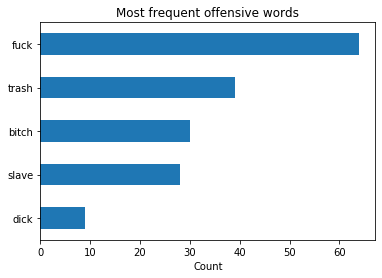

In [171]:
offense = pd.DataFrame.from_dict(count, orient='index').rename(columns={0:"count"}).sort_values("count", ascending=True).tail(5)
offense.plot(kind='barh', legend=False)
plt.title('Most frequent offensive words')
plt.xlabel('Count')
plt.show()

## Partial Directed Graph

I wanted to look at the relations between words with a simple network analysis. Here I create a small directed graph having as nodes the words that constitute the 15 most frequent bigrams and as edges the likelihood ratio, as explained in section 4.2. This part was not meant as in-depth analysis, but I just wanted to touch upon network analysis.

In [173]:
bigram_df = pd.DataFrame.from_dict(dict(scoredList), orient='index').reset_index().rename(columns={0:"value", "index": "bigram"})[:100]

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


trigram_df = pd.DataFrame.from_dict(dict(scoredList_tr), orient='index').reset_index().rename(columns={0:"value", "index": "trigram"})[:10]

# Create dictionary of bigrams and their counts
#d = trigram_df.set_index('trigram').T.to_dict('records')
# Create network plot 
#G3 = nx.Graph()

# Create connections between nodes
#for k, v in d[0].items():
#    print(d[0])
#    G.add_edge(k[0], k[1], weight=(v * 10))
#    G.add_edge(k[1], k[2], weight=(v * 10))


In [174]:
bigram_df = pd.DataFrame.from_dict(dict(scoredList), orient='index').reset_index().rename(columns={0:"value", "index": "bigram"})

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()
GD = nx.DiGraph()


# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

for k, v in d[0].items():
    GD.add_edge(k[0], k[1])


In [213]:
#elimiante trivial bigrams
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[0] == "gon"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[0] == "got"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[0] == "wan"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[0] == "na"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[0] == "ta"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[1] == "gon"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[1] == "got"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[1] == "na"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[1] == "ta"].index, axis=0)
bigram_df = bigram_df.drop(bigram_df.loc[bigram_df.bigram.str[1] == "wan"].index, axis=0)

In [ ]:
#add nodes and edges to directed graph. NB: ONLY THE FIRST 15 BIGRAMS FOR BETTER VISUALIZATION
d = bigram_df.set_index('bigram').T.to_dict('records')
GD = nx.DiGraph()

for k, v in list(d[0].items())[:15]:
    GD.add_edge(k[0], k[1])


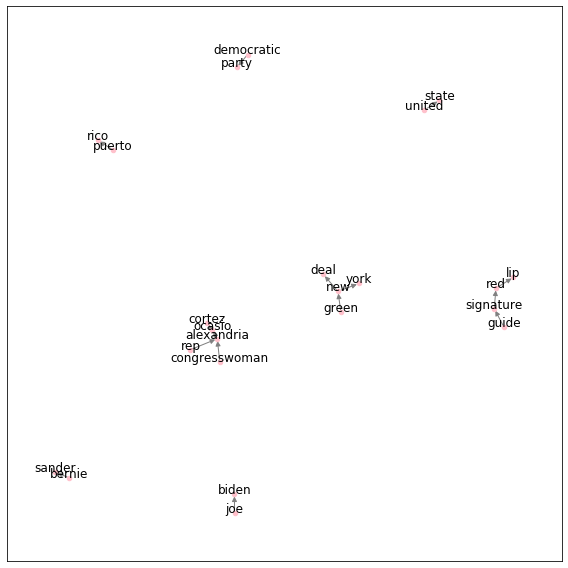

In [265]:
fig, ax = plt.subplots(figsize=(8, 8))
fixed_positions = {"alexandria":(0,0)}
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G, k=5, fixed=fixed_nodes, pos=fixed_positions)

# Plot network
nx.draw_networkx(GD, pos,
                 node_size=20,
                 width = 1,
                 edge_color='grey',
                 node_color='pink',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0], value[1]+0.01
    ax.text(x, y,
            s=key,
            horizontalalignment='center', fontsize=12)


ax.grid(False)
#plt.margins(0.15)
plt.tight_layout()
plt.show()

## Full Directed Graph

I wanted to investigate the main features of the full directed graph having words as nodes. This part was <b>not included in the report</b>.
\
Code was inspired by #inspired by https://stackoverflow.com/questions/53958700/plotting-the-degree-distribution-of-a-graph-using-nx-degree-histogram

In [273]:
complete_directed_graph = nx.DiGraph()

for k, v in d[0].items():
    complete_directed_graph.add_edge(k[0], k[1])

In [274]:
print("Number of nodes:", len(complete_directed_graph.nodes),
      "\nNumber of edges:", len(complete_directed_graph.edges),
      "\nAverage Degree:", len(complete_directed_graph.edges)/len(GD.nodes),
      "\nCheck if it is directed:", complete_directed_graph.is_directed(),
     "\nNumber of connected components:",  nx.number_strongly_connected_components(complete_directed_graph))

Number of nodes: 13967 
Number of edges: 109817 
Average Degree: 7.862604711104747 
Check if it is directed: True 
Number of connected components: 44


In [275]:
#inspired by https://stackoverflow.com/questions/53958700/plotting-the-degree-distribution-of-a-graph-using-nx-degree-histogram

def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

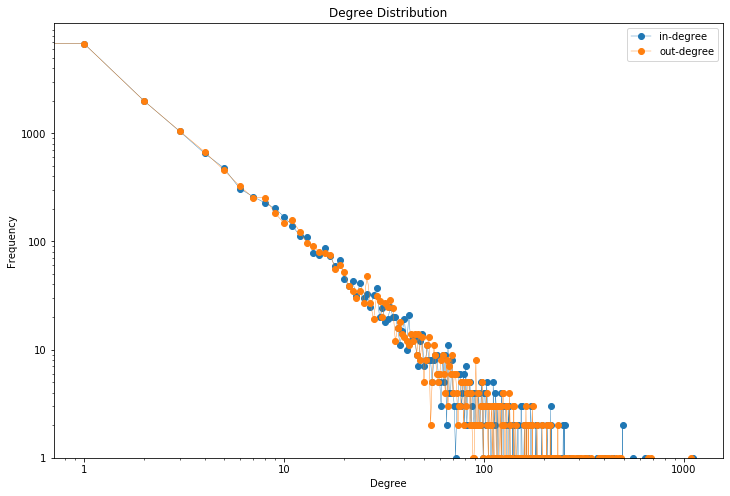

In [319]:
in_degree_freq = degree_histogram_directed(GD, in_degree=True)
out_degree_freq = degree_histogram_directed(GD, out_degree=True)
degrees = range(len(in_degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'o-', label='in-degree', linewidth=0.4) 
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'o-', label='out-degree', linewidth=0.4)
plt.xticks([1, 10, 100, 1000], [1,10,100,1000])
plt.yticks([1, 10, 100, 1000], [1,10,100,1000])
plt.legend()
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.ylim(1)
plt.show()

##  Sentiment Analysis

I wanted to perform a simple and quick sentiment analysis. To do so, I turned to the SentimentIntensityAnalyzer function included in the nltk package. This part was <b>not incuded in the report</b> because a rapid check of the results showed that the classification results are not very accurate.

In [281]:
def sentiment_analyzer_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
    return score["compound"]

def get_sentiment(text):
    score = sentiment_analyzer_scores(text)
    if score < 0:
        return "neg"
    if score >= 0 and score < 0.3:
        return "neu"
    else:
        return "pos"

In [282]:
df["sentiment"] = None

for n, tweet_id in enumerate(df.id):
    text = df.loc[df.id == tweet_id, "clean_text"].values[0]
    df.loc[df.id == tweet_id, "sentiment"] = get_sentiment(text)


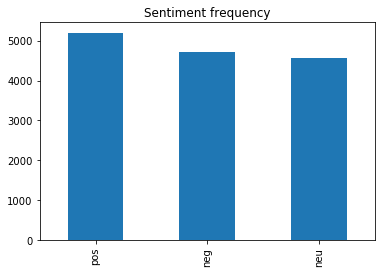

In [283]:
df.drop_duplicates("text").sentiment.value_counts().plot(kind='bar', title="Sentiment frequency", legend=False)
plt.show()

In [316]:
# print 5 random tweets classified as positive
rndm = random.sample(df.drop_duplicates("text").loc[df.sentiment == "pos", "text"].index.tolist(), 5)
print('5 random positive tweets')
for n in rndm:
    print('-', df.loc[n, 'text'])
    print('\n')

5 random positive tweets
- @crsiller @AOC @Jorgensen4POTUS @HowieHawkins Wait, is AOC running for president? Lol 😆


- @skar_of @PatrickRuffini AOC won't win primary. I hope I am right.


- @RomeroWrites @AndrewYang What is he supposed to do when the other side of this is Trump? Support the cause, don’t tear down someone who’s clearly put more thought into this for your well being. Even AOC, the ultimate Bernie bro, is here with the cause. Priorities.


- The DNC has decided that #AOC speech tonight is so important, they have given her segment an official title, worthy of both her, and her speech https://t.co/cuhSp5bAQW


- @ktpearl4 @AOC I don't think my friend is wrong, I just don't think either  word truly fit what's happening here.




In [315]:
# print 5 random tweets classified as negative
rndm = random.sample(df.drop_duplicates("text").loc[df.sentiment == "neg", "text"].index.tolist(), 5)
print('5 random negative tweets')
for n in rndm:
    print('-', df.loc[n, 'text'])
    print('\n')

5 random negative tweets
- @TruthToSurvive @AOC @NWSNHC LOLOLOLOL!!! Or, hurricane Laura is a hoax !


- @AOC @realDonaldTrump you’re so insecure you can’t help but belittle women! Makes you even smaller! #AOC you scorched the man with a tiny brain- his idea of an educational institution is merely a money grab opportunity with no educational outcome!


- Yo, who remembers snail mail and getting letters? Whos with me and how should we implement without giving our addresses to a bunch of strangers? PO boxes? #AOC https://t.co/iYWtqHzBn4


- @BerniceKing @AOC Misleading....


- @Raw_Fan_Nation @Derek_Vasquez @AssembleWe @echavezcal @AOC OOPs looks like old Edgar got outed for being the creep he is... shameful...

https://t.co/IXb51OW4Rk




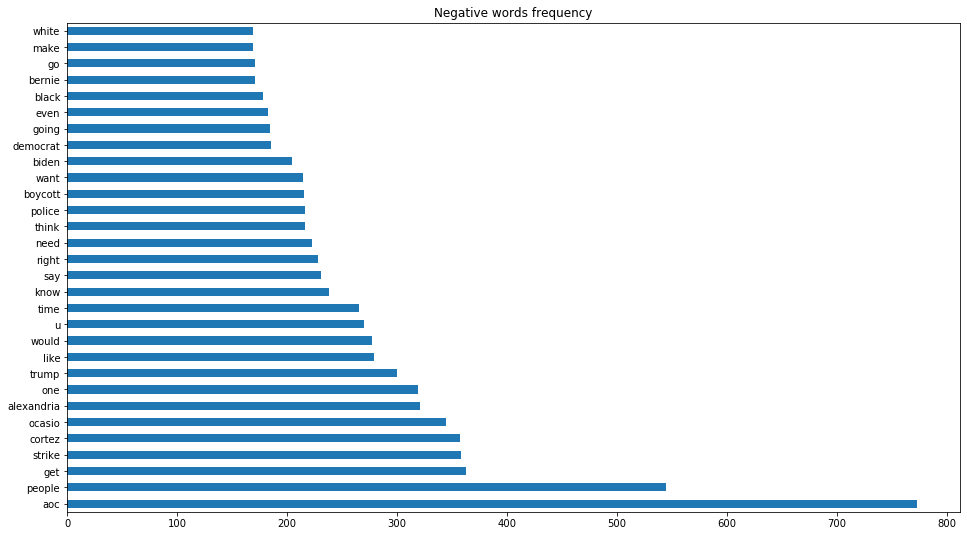

In [287]:
neg_tweets = df.drop_duplicates("text").loc[df.sentiment == "neg", "clean_text"]
neg_corpus = " ".join([item for item in neg_tweets]).split()

neg_counts = Counter(neg_corpus)
neg_df = pd.DataFrame.from_dict(neg_counts, orient='index').rename({"index":"word", 0:"count"}, axis=1).sort_values("count", ascending=False)[:30]

neg_df.plot(kind='barh', figsize=(16,9), title="Negative words frequency", legend=False)
plt.show()


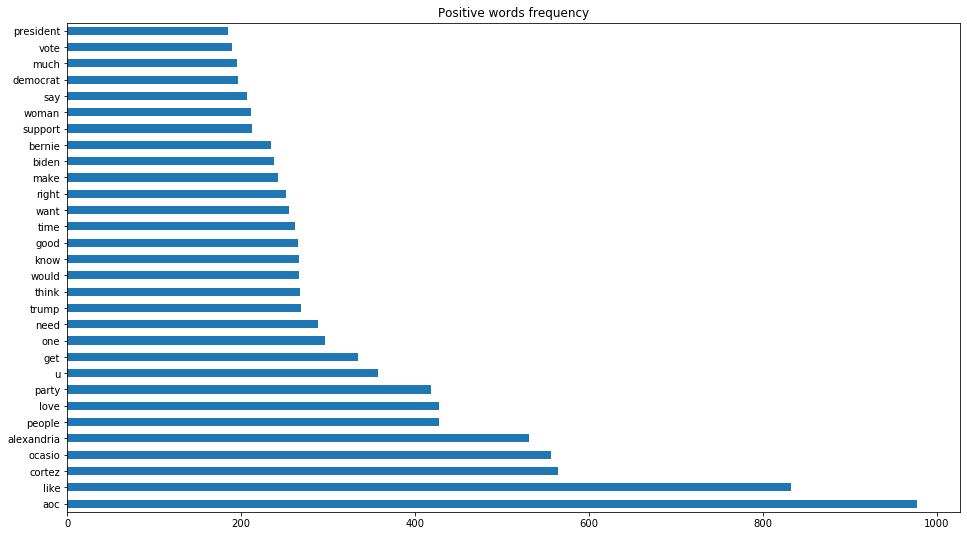

In [317]:
neg_tweets = df.drop_duplicates("text").loc[df.sentiment == "pos", "clean_text"]
neg_corpus = " ".join([item for item in neg_tweets]).split()

neg_counts = Counter(neg_corpus)
neg_df = pd.DataFrame.from_dict(neg_counts, orient='index').rename({"index":"word", 0:"count"}, axis=1).sort_values("count", ascending=False)[:30]

neg_df.plot(kind='barh', figsize=(16,9), title="Positive words frequency", legend=False)
plt.show()


<b>The results on the sentiment analysis carried out with the SentimentIntensityAnalyzer are not encouraging. Better tools are needed and therefore this part will not be included in the report. Moreover, sentiment analysis is beyond the scope of the paper. However, I acknowledge the existence of better methods to perform sentiment analysis. </b>